# Exploring the localization landscape

© 2019, Anton Akhmerov (TU Delft)

BSD 2-clause license, see LICENSE file in this repository

This is a minimal reproduction of the findings *localization landscape* paper, [arXiv:1711.04888](https://arxiv.org/abs/1711.04888), see also a [commentary](https://www.condmatjclub.org/?p=3631) by Carlo Beenakker for a general overview.

Select Run → "run all cells" to view the results

#### Used packages and setup

## Initialization and useful functions

In [2]:
import matplotlib
from matplotlib import pyplot
import numpy as np

import scipy.sparse.linalg
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

import kwant
import mumps

In [3]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['font.size'] = 16

#### We use the MUMPS library (wrapped by Kwant) to get the Green's function.

In [4]:
class LuInv(scipy.sparse.linalg.LinearOperator):
    def __init__(self, A):
        inst = mumps.Context()
        inst.analyze(A)
        inst.factor(A)
        self.solve = inst.solve
        scipy.sparse.linalg.LinearOperator.__init__(self, A.dtype, A.shape)

    def _matvec(self, x):
        return self.solve(x.astype(self.dtype))


def greens_function(hamiltonian, energy=0):
    """Compute the Green's function for a given Hamiltonian and energy."""
    return LuInv(hamiltonian - energy * scipy.sparse.identity(hamiltonian.shape[0]))

#### System geometry

This is a $d$-dimensional cube with optional periodic boundary conditions.

Because we rely on the watershed algorithm from scikit-image (which doesn't implement p.b.c.), we use lattice termination boundary instead.

In [5]:
def nd_cube(L=100, d=1, pbc=False):
    """Create an d-dimensional disordered hypercube with linear size L."""
    def random_potential(site, V, salt):
        """A random onsite potential between 0 and V."""
        return V * kwant.digest.uniform(repr(site), salt) + 2*d

    lat = kwant.lattice.general(np.identity(d), norbs=1)
    cube = kwant.Builder()
    cube[lat.shape((lambda pos: all(0 <= i < L for i in pos)), start=np.zeros((d,)))] = random_potential
    cube[lat.neighbors()] = -1
    # Periodic boundary conditions
    if pbc:
        for direction in (L - 1) * np.identity(d):
            cube[kwant.builder.HoppingKind(direction, lat)] = -1
    
    return cube.finalized()

#### Finally the important part.

Here we define the main computation, which:

1. Gets the Hamiltonian.
2. Computes the Green's function
3. Computes the localization landscape
4. Applies watershed algorithm to compute the localization valleys
5. Uses sparse diagonalization to obtain the lowest eigenvalues and corresponding eigenvectors

In [6]:
def compute_all(d, L, V, salt='', n=None):
    """Compute localization landscape and the eigenspectrum for a given system.
    
    Parameters
    ----------
    d : int
        Dimensionality of the system.
    L : int
        Linear system size.
    V : float
        Strength of the disorder potential: the onsite potential is uniformly distributed in [0, V).
    salt : str
        Parameter controlling random number generation (practically the same as seed).
    n : int
        Number of eigenvalues/eigenvectors to consider. If not provided, compute the same amount
        as the number of localization landscape valleys.

    Returns
    -------
    landscape : d-dimensional float array
        The localization landscape ``1/u``.
    minima : 1d float array
        Values of the localization landscape minima (unsorted).
    energies : 1d float array
        Lowest eigenenergies.
    vectors : d+1-dimensional float array
        Eigenvectors (the second coordinate is the eigenvector index).
    labels : 2-dimensional integer array
        Markers identifying the localization landscape valleys.
    """
    syst = nd_cube(L=L, d=d)
    hamiltonian = syst.hamiltonian_submatrix(params=dict(V=V, salt=salt), sparse=True)

    gf = greens_function(hamiltonian)
    u = (gf @ np.ones(hamiltonian.shape[0])).real
    landscape = 1/u.reshape(d*[L])

    minima_loc = peak_local_max(
        -landscape,
        exclude_border=False,
    )
    mask = np.zeros_like(landscape, dtype=bool)
    mask[tuple(minima_loc.T)] = True
    markers, n_valleys = ndimage.label(mask)

    labels = watershed(landscape, markers)
    minima = landscape[markers.astype(bool)]
    
    # Relabel the valleys, so that the indexing starts from 0, and
    order = np.argsort(minima)
    labels = np.argsort(order)[labels.flatten() - 1].reshape(labels.shape)
    energies, vectors = scipy.sparse.linalg.eigsh(
        hamiltonian, k=(n or n_valleys), sigma=0, OPinv=gf
    )
    return landscape, minima[order], energies, vectors, labels


# Example: 2D

#### Get all the data.

In [7]:
landscape, minima, energies, vectors, valleys = compute_all(d=2, L=50, V=1, n=40)

Here's the localization landscape and its valleys

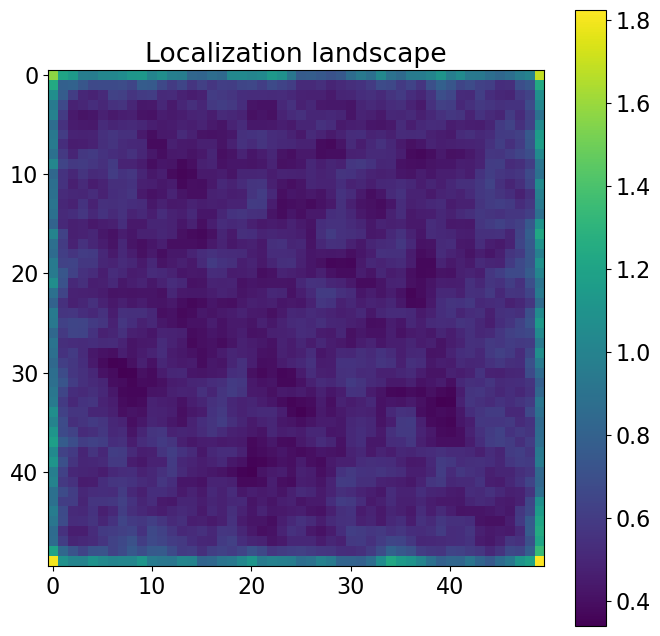

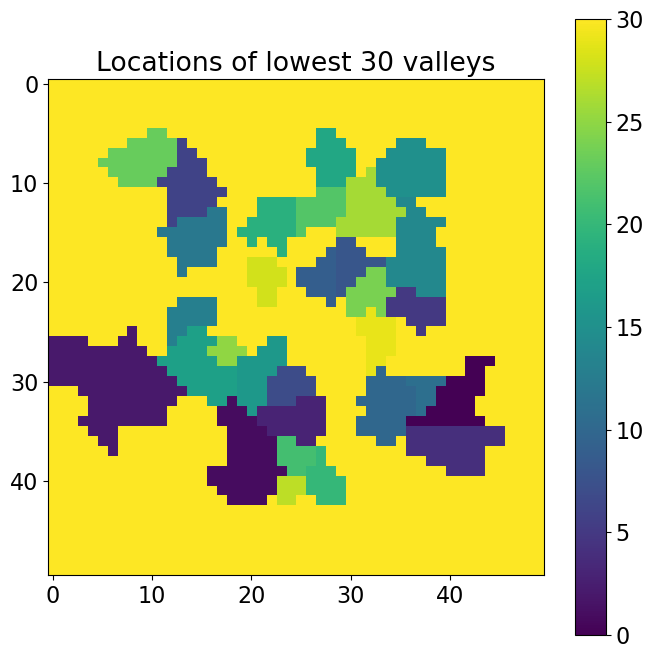

In [8]:
pyplot.imshow(landscape)
pyplot.colorbar()
pyplot.title('Localization landscape')
pyplot.figure()
pyplot.imshow(valleys)
n_valleys = 30
pyplot.title(f'Locations of lowest {n_valleys} valleys')
pyplot.clim((0, n_valleys))
pyplot.colorbar();

The ratio between each eigenenergy and each landscape valley is close to the predicted value of $1 + d/4 = 1.5$.

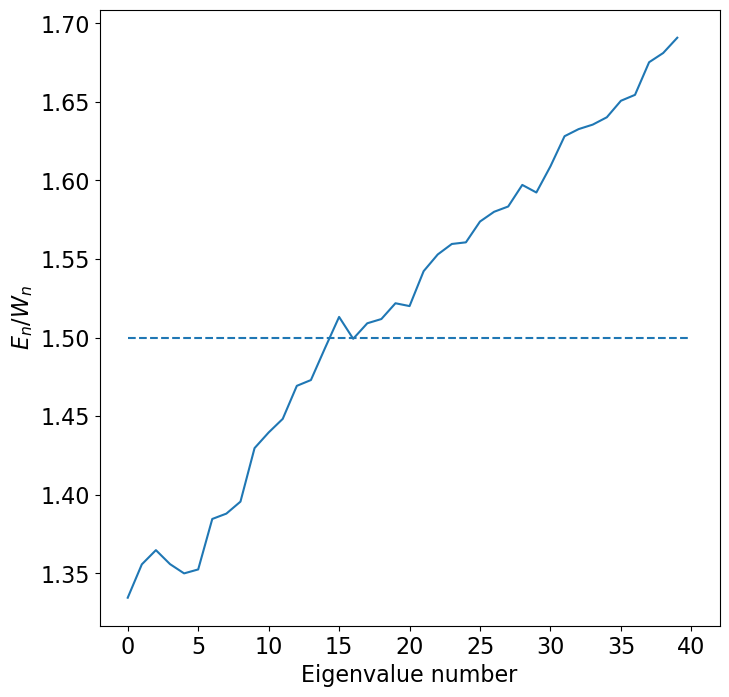

In [9]:
pyplot.plot(energies / minima[:len(energies)])
pyplot.xlabel("Eigenvalue number")
pyplot.ylabel('$E_n / W_n$');
pyplot.hlines(1.5, 0, len(energies), linestyles='dashed');

The preprint predicts that each eigenvector is localized within 1 valley.

In [10]:
weights = np.array([(valleys.flatten() == i) @ np.abs(vectors**2) for i in range(len(minima))])

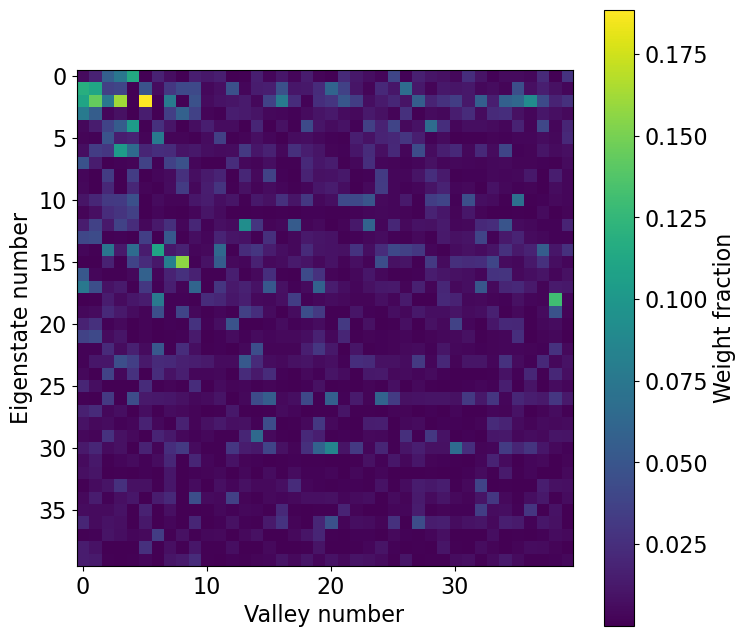

In [11]:
pyplot.imshow(weights[:vectors.shape[1]])
pyplot.xlabel('Valley number')
pyplot.ylabel('Eigenstate number')
cbar = pyplot.colorbar()
cbar.set_label('Weight fraction')